# CIFAST

The task is to train a model on CIFAR-100 dataset, which will not exceed 150k parameters and will train in less than 0.5 hour. 

## Dependencies

In [1]:
# !pip install tensorflow-gpu==2
# !pip install -q git+https://github.com/tensorflow/docs
# !pip install tensorflow_addons

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar100, cifar10
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tensorflow import image as tf_img
from tensorflow_docs import plots as tfplots
import tensorflow_addons as tfa
from pathlib import Path
import pickle
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics as skmetrics
from time import time

## Data

I split the original CIFAR100 training images into a train and validation dataset of 45k and 5k images, respectively.

First, I load the data and normalize them by:

* dividing pixel values by 255
* subtracting the per-channel mean and dividing by per-channel std deviation.

Mean and std are obtained from train images only.

In [4]:
(x,y_fine), (x_test, y_test) = cifar100.load_data("fine")

x_train, x_val, y_train, y_val = train_test_split(
    x, y_fine, test_size=5000, random_state=0
)

x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test,))
ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val, ))
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train, ))

In [5]:
DS_MEAN = x_train.mean(axis=(0, 1, 2))
DS_STD = x_train.std(axis=(0,1, 2))

def normalize(img):
    return (img - DS_MEAN) / DS_STD

x_train.shape, DS_MEAN, DS_STD 

((45000, 32, 32, 3),
 array([0.50659685, 0.48631419, 0.44058018]),
 array([0.26733804, 0.25652245, 0.27617526]))

Let's examine some photos before and after normalization:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


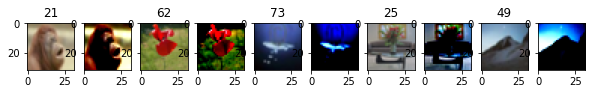

In [6]:
n = 5
fig, ax = plt.subplots(ncols=2*n, figsize=(10, 10*2*n))

for i, (img, l) in enumerate(list(zip(x_train, y_train,))[:5]):
    ax[2*i].imshow(img)
    ax[2*i +1].imshow(normalize(img))
    ax[2*i].set_title(f"{int(l)}")


## Augmentation

I've tried augmenting the dataset through:

* horizontal flipping
* random cropping
* changing color saturation

Of the above, only image flipping yielded noticeable improvements. Therefore, it's the only part of the augmentation pipeline.

In [8]:
def to_model_input(img, label):
    img = normalize(img)
    return img, label

def augmentation(img, label):
    img = tf_img.random_flip_left_right(img)
    # img = tf_img.random_brightness(img, max_delta=0.3)

    # c_h = np.random.randint(24, 32)
    # c_w = np.random.randint(24, 32)
    # img = tf_img.random_crop(img, [c_h, c_w, 3])
    # img = tf_img.random_saturation(img, 0.7, 1.3)
    # img = tf_img.resize(img, (32, 32))
    return img, label

## Model

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, maximum
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow.keras as k
from tensorflow.keras.regularizers import l2

My model is built up of a convolutional backbone with multiple "residual" blocks, where the input is passed through three convolutions + relu + batchnorm blocks and the output of that is added to the input, and passed though an additional batchnorm.. Between those blocks, there are strided convolutions in order to downsample the featuremaps.

The final featuremap is flattened and passed through a dense layer which performs classification. I also utilize dropout layers in order to better regularize the model.

According to Keras utilities, the model takes up ~148k parameters in total.

In [10]:
def conv_block(out_channels: int):
    return k.models.Sequential([
      k.layers.Conv2D(
          out_channels, 3, padding="same", activation="relu", #kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)
        ),
      k.layers.BatchNormalization(),
      k.layers.Dropout(0.3)
    ])

class ResWrapper(tf.keras.layers.Layer):
    def __init__(self, sub_net, **kwargs):
        super(ResWrapper, self).__init__(**kwargs)
        self.sub_net = sub_net
        self.bn = k.layers.BatchNormalization()
    
    def call(self, x):
        return self.bn(x + self.sub_net(x))

In [21]:
backbone = Sequential([
    k.layers.Conv2D(32, 3, activation="relu", padding='same', input_shape=(32, 32, 3)),
    ResWrapper(
        Sequential([
            conv_block(32),
            conv_block(32),
        ])
    ),
    k.layers.Conv2D(8, 3, padding="same", strides=2),
    conv_block(32),
    ResWrapper(
        Sequential([
            conv_block(32),
            conv_block(32),
            conv_block(32),
        ])
    ),
    k.layers.Conv2D(12, 3, padding="same", strides=2),
    conv_block(32),
    ResWrapper(
        Sequential([
            conv_block(32),
            conv_block(32),
            conv_block(32),
        ])
    ),   
    k.layers.Conv2D(32, 3, padding="same", strides=2),
])
model = Sequential([
    backbone,
    k.layers.Flatten(),
    k.layers.Dropout(0.2),
    Dense(100, activation="softmax")
])


model.summary()

Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_133 (Sequential)  (None, 4, 4, 32)          97396     
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_98 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               51300     
Total params: 148,696
Trainable params: 147,864
Non-trainable params: 832
_________________________________________________________________


## Training

Training is made up of two phases:

* 40 epochs for training the entire model
* 40 epochs for finetuning only the final dense layer

During each of those phases, model is trained with an Adam optimizer. Each time, the initial learning rate is $6^{-4}$ and is downgraded by each 5 epochs.

I tested other optimizers, such as Lookahead and RectifiedAdam, but plain old Adam proved the best.

Each epoch takes ~20 seconds, hence training the model for 100 epoch takes less than half an hour.

In [22]:
full_epochs = 40
finetune_epochs = 40
start_time = time()

lr = 6e-4

def schedule_fn(base_lr, decay):
    def schedule(epoch):
        if True: #epoch > 25:
            epoch = min(epoch,80)
            return base_lr * (decay ** (epoch // 5))
        return base_lr
    return schedule

scheduler = k.callbacks.LearningRateScheduler(schedule_fn(lr, 0.85), verbose=True)

# lr = tf.keras.experimental.CosineDecayRestarts(6e-4, 1000,m_mul=0.8)
callbacks = [
  scheduler
]

optimizer = Adam(lr)


model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(),
    metrics=[
        "accuracy"
    ],
)


result_1 = model.fit(
        ds_train.shuffle(buffer_size=50000).map(
            augmentation
        ).map(
            to_model_input
        ).batch(64), 

    epochs=full_epochs, 
    validation_data=ds_val.map(to_model_input).batch(128),
    callbacks=callbacks
)

model.layers[0].trainable = False

result_2 = model.fit(
        ds_train.shuffle(buffer_size=50000).map(
            augmentation
        ).map(
            to_model_input
        ).batch(64), 
    initial_epoch = 0, #full_epochs,
    epochs= finetune_epochs, 
    validation_data=ds_val.map(to_model_input).batch(128),
    callbacks=callbacks
)



history = {
    k: result_1.history[k] + result_2.history[k]
    for k in result_1.history.keys()
}

end_time = time()

print(f"training time: {end_time - start_time} seconds")

Train for 704 steps, validate for 40 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0006.
Epoch 1/40
704/704 [==============================] - 20s 28ms/step - loss: 4.3811 - accuracy: 0.0545 - val_loss: 3.8874 - val_accuracy: 0.1080

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0006.
Epoch 2/40
704/704 [==============================] - 17s 24ms/step - loss: 3.7711 - accuracy: 0.1279 - val_loss: 3.4560 - val_accuracy: 0.1732

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0006.
Epoch 3/40
704/704 [==============================] - 16s 23ms/step - loss: 3.4278 - accuracy: 0.1862 - val_loss: 3.2342 - val_accuracy: 0.2148

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0006.
Epoch 4/40
704/704 [==============================] - 17s 24ms/step - loss: 3.1918 - accuracy: 0.2251 - val_loss: 2.9842 - val_accuracy: 0.2596

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0006.
Epoch 5/40
704/704 [===========

In [23]:
experiment_name = "res_wrapper_finetune_40_40"


results_path = Path("results")
results_path.mkdir(exist_ok=True)
histories = dict()

for p in results_path.glob("*.pkl"):
    with p.open("rb") as f:
        histories[p.stem] = pickle.load(f)
        
assert experiment_name not in histories.keys(), experiment_name
histories[experiment_name] = history

with (results_path / f"{experiment_name}.pkl").open("wb") as f:
    pickle.dump(history, f)

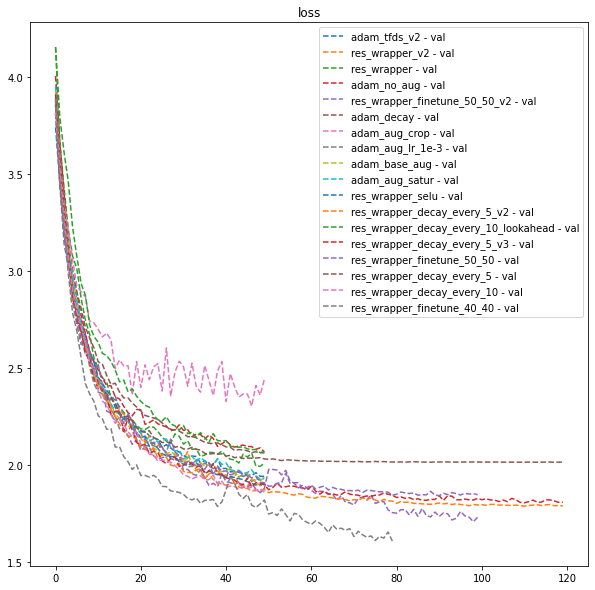

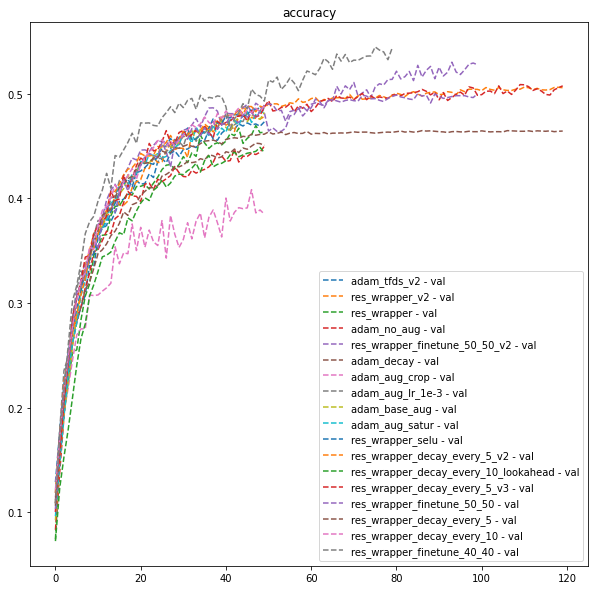

In [24]:
metrics = [n for n in list(histories.values())[0].keys() if "val" not in n]

for n in metrics:
    plt.figure(figsize=(10,10))

    plt.title(n)
    for exp_name, exp_history in histories.items():
        train_history, val_history = [exp_history.get(f"{prefix}{n}", []) for prefix in ["", "val_"]]
#         plt.plot(
#             list(range(len(train_history))),
#             train_history,
#             label=f"{exp_name} - train"
#         )
        plt.plot(
            list(range(len(val_history))),
            val_history,
            linestyle="--",
            label=f"{exp_name} - val"
        )
        
    
    plt.legend()
    plt.show()

In [25]:

y_val_pred = model.predict(ds_val.map(to_model_input).batch(1000))
y_val_pred_logits = y_val_pred.argmax(axis=1)

In [26]:
print(skmetrics.classification_report(
    y_val, y_val_pred_logits
))

skmetrics.confusion_matrix(y_val, y_val_pred_logits)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        58
           1       0.59      0.75      0.66        44
           2       0.34      0.34      0.34        47
           3       0.42      0.29      0.34        55
           4       0.30      0.38      0.33        37
           5       0.45      0.63      0.52        46
           6       0.37      0.49      0.42        39
           7       0.60      0.52      0.56        46
           8       0.74      0.75      0.75        53
           9       0.77      0.63      0.69        57
          10       0.26      0.24      0.25        42
          11       0.42      0.27      0.33        63
          12       0.76      0.64      0.69        53
          13       0.53      0.42      0.47        43
          14       0.60      0.43      0.50        42
          15       0.65      0.41      0.50        54
          16       0.51      0.57      0.54        44
          17       0.70    

array([[39,  1,  0, ...,  0,  0,  0],
       [ 0, 33,  0, ...,  0,  0,  1],
       [ 0,  0, 16, ...,  0,  4,  0],
       ...,
       [ 0,  0,  0, ..., 29,  0,  0],
       [ 0,  0,  3, ...,  0, 12,  0],
       [ 0,  0,  0, ...,  0,  0, 29]])

## Test set accuracy

In [27]:
model.evaluate(ds_test.map(to_model_input).batch(256))

40/40 [==============================] - 2s 48ms/step - loss: 1.6441 - accuracy: 0.5486


[1.644094717502594, 0.5486]